<div class="alert alert-info">
<h2> Проект спринта. Retrieval-система по статьям с arXiv</h2>



</div>


<font color='red'>

In [1]:

%pip install -r nlp4_req.txt 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 46.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 68.6 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 59.2 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.4/584.4 kB 31.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 3.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.9 MB/s  0:00:00
   ━━━

In [2]:
%pip install langchain langchain-community langchain-core faiss-gpu matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
# 1. Импорты библиотек

from typing import List, Optional, Dict, Tuple
import os
import json
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm
import time
import gc
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
import torch
from torch import Tensor
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')


/home/ubuntu/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div class="alert alert-info">
<h2> Датасет arXiv и тестовые запросы</h2>


Загрузка и обработка
</div>


<font color='red'>

In [2]:
# Проверка наличия папок и файлов
import sys
from pathlib import Path

# Просмотр текущей рабочей директории
print("Текущая рабочая директория:")
print(f"os.getcwd(): {os.getcwd()}")
#print(f"Path.cwd(): {Path.cwd()}")
print()

# Просмотр содержимого текущей директории
print("Содержимое текущей директории:")
print("Файлы и папки:")
items = os.listdir()
for item in items:
    item_path = Path(item)
    if item_path.is_dir():
        print(f"📁 {item}/")
    else:
        print(f"📄 {item} ({item_path.stat().st_size} bytes)")
print()


Текущая рабочая директория:
os.getcwd(): /home/ubuntu

Содержимое текущей директории:
Файлы и папки:
📄 .wget-hsts (183 bytes)
📁 .vscode-server/
📄 .profile (807 bytes)
📁 .venv/
📄 .bash_logout (220 bytes)
📁 .dotnet/
📁 .nv/
📁 .cache/
📁 .ipython/
📁 .ssh/
📄 .bashrc (3771 bytes)
📄 RAG_sys_exp_large_size.ipynb (482804 bytes)
📄 arxiv-metadata-s.json (231636178 bytes)
📁 .local/
📄 test_sample.csv (1138529 bytes)
📄 RAG_sys_exp_small_size.ipynb (814325 bytes)
📄 .sudo_as_admin_successful (0 bytes)
📁 .config/
📄 nlp4_req.txt (2992 bytes)



In [3]:
# 2: Загрузка и анализ датасета и тестовых данных

# 2.1 загрузка arxiv-metadata-s.json, отфильтрованного по "id", "title", "categories", "abstract"

import json
import time
import sys
import os
from tqdm import tqdm

ARXIV_DATA_PATH = "./arxiv-metadata-s.json"

def load_all_arxiv_data(file_path, filter_fields=None):
    """
    Загрузка записей из arXiv датасета

    """
    print(f"Загрузка записей из {file_path}")
    print(f"Размер файла: {os.path.getsize(file_path):,} байт")
    
    # Оценка необходимой памяти
    
    file_size = os.path.getsize(file_path)
    estimated_memory = file_size * 3  # Примерный множитель для данных в памяти
    print(f"Примерно потребуется: {estimated_memory / (1024**3):.1f} GB оперативной памяти")
    
    response = input("Продолжить? (y/n): ")
    if response.lower() != 'y':
        print("Загрузка отменена")
        return None
    
    start_time = time.time()
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            all_data = json.load(f)
        
        elapsed = time.time() - start_time
        print(f"✓ Загружено ВСЕХ {len(all_data):,} записей за {elapsed:.2f} секунд")
        
        # Фильтрация полей если нужно
        if filter_fields:
            print(f"Фильтрация полей: {filter_fields}")
            filtered_data = []
            for item in tqdm(all_data, desc="Фильтрация"):
                filtered_item = {field: item.get(field) for field in filter_fields}
                filtered_data.append(filtered_item)
            print(f"Отфильтровано {len(filtered_data)} записей")
            return filtered_data
        
        return all_data
        
    except MemoryError:
        print("✗ ОШИБКА ПАМЯТИ: Недостаточно оперативной памяти!")
        print("Рекомендации:")
        print("1. Используйте filter_fields для загрузки только нужных полей")
        print("2. Используйте потоковую загрузку (см. вариант 2)")
        print("3. Увеличьте объем оперативной памяти")
        return None

# Использование: загрузка ВСЕХ записей
#all_data = load_all_arxiv_data('./data/arxiv-metadata-s.json')

# ИЛИ загрузка только нужных полей 
filter_fields = ['id', 'title', 'categories', 'abstract']
all_data_filtered = load_all_arxiv_data(
    file_path=ARXIV_DATA_PATH, 
    filter_fields=filter_fields
)

#Вывод примеров
print("Первые 3 статьи, отфильтрованные по id, title, categories, abstract:")
print("=" * 55)

for i, record in enumerate(all_data_filtered[:3], 1):
    print(f"\nСтатья #{i}:")
    for key, value in record.items():
        if value:
            # Обрезаем длинные строки
            if isinstance(value, str) and len(value) > 200:
                value_preview = value[:100] + "..."
            else:
                value_preview = str(value)
            print(f"  {key}: {value_preview}")
        else:
            print(f"  {key}: None")
    print("-" * 55)

Загрузка записей из ./arxiv-metadata-s.json
Размер файла: 231,636,178 байт
Примерно потребуется: 0.6 GB оперативной памяти


✓ Загружено ВСЕХ 98,213 записей за 3.70 секунд
Фильтрация полей: ['id', 'title', 'categories', 'abstract']


Фильтрация: 100%|██████████| 98213/98213 [00:00<00:00, 772174.80it/s]

Отфильтровано 98213 записей


Первые 3 статьи, отфильтрованные по id, title, categories, abstract:

Статья #1:
  id: 0704.0038
  title: The discrete dipole approximation: an overview and recent developments
  categories: physics.optics physics.comp-ph
  abstract:   We present a review of the discrete dipole approximation (DDA), which is a
general method to simul...
-------------------------------------------------------

Статья #2:
  id: 0704.0057
  title: High-spin to low-spin and orbital polarization transitions in
  multiorbital Mott systems
  categories: cond-mat.str-el
  abstract:   We study the interplay of crystal field splitting and Hund coupling in a
two-orbital model which c...
-------------------------------------------------------

Статья #3:
  id: 0704.0060
  title: Coulomb excitation of unstable nuclei at intermediate energies
  categories: nucl-th
  abstract:   We investigate the Coulomb excitation of low-lying states of unstable nuclei
in intermediate energ...
---------------------------------------

In [4]:
# Анализ процентилей
print("=" * 60)
print("АНАЛИЗ ПРОЦЕНТИЛЕЙ ДЛИН ABSTRACT")
print("=" * 60)

if all_data_filtered:
    # Собираем длины abstract
    abstract_lengths = []
    for record in all_data_filtered:
        abstract = record.get('abstract', '')
        if abstract and abstract.strip():
            words = abstract.split()
            abstract_lengths.append(len(words))
    
    if abstract_lengths:
        # Вычисляем процентили
        percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99, 99.5, 99.9, 100]
        
        print(f"Всего статей с abstract: {len(abstract_lengths):,}")
        print(f"Общее количество статей: {len(all_data_filtered):,}")
        
        print("\nПроцентиль | Длина (слов) | Длина (символов*)")
        print("-" * 50)
        
        for p in percentiles:
            word_length = np.percentile(abstract_lengths, p)
            char_length_est = word_length * 7  # Оценка в символах
            print(f"{p:6.1f}%     | {word_length:8.1f}     | {char_length_est:8.0f}")
        
        print("\n* Оценка: 7 символов на слово (включая пробелы)")
        
        # Топ самых коротких
        print("\n" + "=" * 60)
        print("ТОП САМЫХ КОРОТКИХ ABSTRACT")
        print("=" * 60)
        
        # Сортируем индексы по длине abstract
        articles_with_lengths = []
        for i, record in enumerate(all_data_filtered):
            abstract = record.get('abstract', '')
            if abstract and abstract.strip():
                word_count = len(abstract.split())
                articles_with_lengths.append((i, word_count, record))
        
        # Сортируем по длине
        articles_with_lengths.sort(key=lambda x: x[1])
        
        # Выводим топ-Х
        for rank, (idx, word_count, record) in enumerate(articles_with_lengths[:3], 1):
            print(f"\n{rank}. ID: {record.get('id', 'unknown')}")
            print(f"   Длина: {word_count} слов ≈ {word_count * 7} символов")
            print(f"   Заголовок: {record.get('title', '')[:80]}...")
            abstract = record.get('abstract', '')
            if len(abstract) > 150:
                print(f"   Abstract: {abstract[:150]}...")
            else:
                print(f"   Abstract: {abstract}")
            print(f"   Категории: {record.get('categories', 'не указаны')}")

АНАЛИЗ ПРОЦЕНТИЛЕЙ ДЛИН ABSTRACT
Всего статей с abstract: 98,213
Общее количество статей: 98,213

Процентиль | Длина (слов) | Длина (символов*)
--------------------------------------------------
   1.0%     |     24.0     |      168
   5.0%     |     47.0     |      329
  10.0%     |     63.0     |      441
  25.0%     |     96.0     |      672
  50.0%     |    140.0     |      980
  75.0%     |    188.0     |     1316
  90.0%     |    234.0     |     1638
  95.0%     |    256.0     |     1792
  99.0%     |    288.0     |     2016
  99.5%     |    297.0     |     2079
  99.9%     |    313.0     |     2191
 100.0%     |    584.0     |     4088

* Оценка: 7 символов на слово (включая пробелы)

ТОП САМЫХ КОРОТКИХ ABSTRACT

1. ID: astro-ph/0511670
   Длина: 2 слов ≈ 14 символов
   Заголовок: Island Universes...
   Abstract:   Conference Summary

   Категории: astro-ph

2. ID: astro-ph/9711336
   Длина: 3 слов ≈ 21 символов
   Заголовок: Structure formation by cosmic strings with a cosmolog

In [5]:
# 2.2: функции загрузки и анализа данных датасета

@dataclass
class DatasetStats:
    """Статистика датасета"""
    total_records: int
    avg_title_length: int
    avg_abstract_length: int
    categories_distribution: Dict[str, int]
    text_length_stats: Dict[str, float]

def analyze_filtered_data(all_data_filtered: List[dict]) -> DatasetStats:
    """Анализ отфильтрованных данных arXiv"""
    
    
    print(f"Загружено статей: {len(all_data_filtered):,}")
    
    # Проверяем структуру данных
    if len(all_data_filtered) > 0:
        sample_record = all_data_filtered[0]
        print("\nСтруктура записи:")
        for key in sample_record.keys():
            print(f"  - {key}: {type(sample_record[key])}")
    
    # Собираем статистику
    titles = []
    abstracts = []
    categories_counter = defaultdict(int)
    
    for record in tqdm(all_data_filtered, desc="Обработка записей"):
        title = record.get('title', '')
        abstract = record.get('abstract', '')
        
        titles.append(title if title else '')
        abstracts.append(abstract if abstract else '')
        
        # Обрабатываем категории
        categories = record.get('categories', '')
        if categories:
            for cat in categories.split():
                categories_counter[cat] += 1
    
    # Вычисляем статистику по длине текста
    title_lengths = [len(str(title).split()) for title in titles]
    abstract_lengths = [len(str(abstract).split()) for abstract in abstracts]
    
    # Фильтруем нулевые значения
    title_lengths = [l for l in title_lengths if l > 0]
    abstract_lengths = [l for l in abstract_lengths if l > 0]
    
    stats = DatasetStats(
        total_records=len(all_data_filtered),
        avg_title_length=np.mean(title_lengths) if title_lengths else 0,
        avg_abstract_length=np.mean(abstract_lengths) if abstract_lengths else 0,
        categories_distribution=dict(sorted(categories_counter.items(), 
                                          key=lambda x: x[1], reverse=True)[:10]),
        text_length_stats={
            'title_mean': np.mean(title_lengths) if title_lengths else 0,
            'title_std': np.std(title_lengths) if title_lengths else 0,
            'title_min': np.min(title_lengths) if title_lengths else 0,
            'title_max': np.max(title_lengths) if title_lengths else 0,
            'abstract_mean': np.mean(abstract_lengths) if abstract_lengths else 0,
            'abstract_std': np.std(abstract_lengths) if abstract_lengths else 0,
            'abstract_min': np.min(abstract_lengths) if abstract_lengths else 0,
            'abstract_max': np.max(abstract_lengths) if abstract_lengths else 0,
        }
    )
    
    return stats

def analyze_test_dataset(file_path: str) -> pd.DataFrame:
    """Анализ тестового датасета"""
    print(f"\nЗагрузка тестового датасета из {file_path}...")
    df = pd.read_csv(file_path)
    
    print(f"Статистика тестового датасета:")
    print(f"Количество строк: {len(df)}")
    print(f"Средняя длина query: {df['query'].apply(lambda x: len(str(x).split())).mean():.1f}")
    print(f"Средняя длина abstract: {df['abstract'].apply(lambda x: len(str(x).split())).mean():.1f}")
# Проверяем уникальность ID
    unique_ids = df['id'].nunique()
    print(f"Уникальных ID: {unique_ids}/{len(df)}")
    
    # Анализ распределения длин
    query_lengths = df['query'].apply(lambda x: len(str(x).split()))
    abstract_length = df['abstract'].apply(lambda x: len(str(x).split()))
    print(f"\nДлина query:")
    print(f"  Min: {query_lengths.min()}, Max: {query_lengths.max()}")
    print(f"\nДлина abstract:")
    print(f"  Min: {abstract_length.min()}, Max: {abstract_length.max()}")
    #print(f"  25%: {query_lengths.quantile(0.25):.1f}, 50%: {query_lengths.quantile(0.5):.1f}, "
    #      f"75%: {query_lengths.quantile(0.75):.1f}")
    
    return df


In [6]:
# 2.3: датасет arXiv

stats = analyze_filtered_data(all_data_filtered)
    
print(f"\nСтатистика отфильтрованных данных arXiv:")
print(f"Всего статей: {stats.total_records:,}")
print(f"Средняя длина title: {stats.avg_title_length:.1f} слов")
print(f"Min длинна title: {stats.text_length_stats['title_min']:.1f} слов")
print(f"Max длинна title: {stats.text_length_stats['title_max']:.1f} слов")
print(f"Средняя длина abstract: {stats.avg_abstract_length:.1f} слов")
print(f"Min длинна abstract: {stats.text_length_stats['abstract_min']:.1f} слов")
print(f"Max длинна abstract: {stats.text_length_stats['abstract_max']:.1f} слов")
#print(f"\nТоп-5 категорий:")
#for cat, count in list(stats.categories_distribution.items())[:5]:
#    print(f"  {cat}: {count}")


Загружено статей: 98,213

Структура записи:
  - id: <class 'str'>
  - title: <class 'str'>
  - categories: <class 'str'>
  - abstract: <class 'str'>


Обработка записей: 100%|██████████| 98213/98213 [00:00<00:00, 788878.85it/s]



Статистика отфильтрованных данных arXiv:
Всего статей: 98,213
Средняя длина title: 9.8 слов
Min длинна title: 1.0 слов
Max длинна title: 61.0 слов
Средняя длина abstract: 143.8 слов
Min длинна abstract: 2.0 слов
Max длинна abstract: 584.0 слов


In [7]:
# 2.4: тестовый датасет
TEST_DATA_PATH = "test_sample.csv"
test_df = analyze_test_dataset(TEST_DATA_PATH)

def print_test_records_detailed(df):
    """Подробный вывод тестовых записей"""
    print("\nПримеры из тестового датасета")
    print("=" * 55)
    
    for i in range(min(3, len(df))):
        
        print(f"\nЗапись {i+1}")
        
        # Получаем запись как словарь
        record = df.iloc[i].to_dict()
        
        # Выводим все поля
        for key, value in record.items():
            if pd.isna(value):
                print(f"{key}: [ПУСТО]")
            else:
                # Обрезаем длинные строки
                str_value = str(value)
                if len(str_value) > 100:
                    print(f"{key}: {str_value[:99]}...")
                else:
                    print(f"{key}: {str_value}")
        
        print(f"{'-'*55}")


print_test_records_detailed(test_df)


Загрузка тестового датасета из test_sample.csv...
Статистика тестового датасета:
Количество строк: 1000
Средняя длина query: 18.1
Средняя длина abstract: 145.4
Уникальных ID: 1000/1000

Длина query:
  Min: 7, Max: 42

Длина abstract:
  Min: 16, Max: 528

Примеры из тестового датасета

Запись 1
id: 2412.16732
abstract:   A new platinate was recently discovered when Nd2O3 was explored as a platinum
capture material in...
query: What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O2...
-------------------------------------------------------

Запись 2
id: nucl-th/9602019
abstract:   The production cross sections of various fragments from proton-induced
reactions on $^{56}$Fe and...
query: How does the inclusion of statistical decay affect the shape of mass and charge distributions in qu...
-------------------------------------------------------

Запись 3
id: 2501.05500
abstract:   This survey provides a comprehensive examination of verifiable c

<div class="alert alert-info">
<h2> Выводы в результатах анализа датасета и тестовых данных </h2>

1. Датасет содержит тексты академических и/или технических статей, есть терминология. Для решения задачи надо искать модели, обученные на данном домене и показывающие лучшие результаты. Буду использовать на первом шаге: embedder BAAI/bge-base-en-v1.5, reranker BAAI/bge-reranker-base. Если не достигну метрики, на следующем шаге буду использовать модели: embedder BAAI/bge-large-en-v1.5, reranker BAAI/bge-reranker-v2-m3.

2. Title тексты короткие, большой разброс длинн, для моделей может быть проблематично выделить семантику.   Abstract содержит тексты разной длинны, большой разброс длинн. Для embedding лучше сделать title+abstract, возможно + categories, для улучшения семантики. 

3. Бейзлайн реализую на embedder BAAI/bge-base-en-v1.5, reranker BAAI/bge-reranker-base, без дополнительных оптимизаций

4. С учетом достигнутой метрики MRR@5, следующий шаг буду делать с учетом оптимизаций: BM25, гибридный поиск, адаптивный чанк.

5. Если метрика в результате 3-4 не будет достигнута, перейду к моделям embedder BAAI/bge-large-en-v1.5, reranker BAAI/bge-reranker-v2-m3.

</div>


<font color='red'>

<div class="alert alert-info">
<h2> Переходим к моделям </h2>



</div>


<font color='red'>

In [16]:
%pip install sentence_transformers numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


<div class="alert alert-info">
<h2> Вариант 1 </h2>


Модели: BAAI/bge-base-en-v1.5 и BAAI/bge-reranker-base (без наворотов)
</div>


<font color='red'>

In [8]:
import torch
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
#from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
import faiss
from tqdm import tqdm
import torch.nn.functional as F


ЗАПУСК ОПТИМИЗИРОВАННОЙ BGE RAG СИСТЕМЫ
Embedder: BAAI/bge-base-en-v1.5
Reranker: BAAI/bge-reranker-base
Используем 98,213 записей
Загружен тестовый датасет: 1000 записей

Инициализация BGE RAG системы...
Используется устройство: cuda
Загрузка BGE embedder модели...
Загрузка BGE reranker модели...

Используем 98213 записей для построения индекса...
Подготовка документов...


Обработка статей: 100%|██████████| 98213/98213 [00:04<00:00, 22115.71it/s]


Создано 227898 чанков из 98213 статей
Генерация эмбеддингов...


Эмбеддинги: 100%|██████████| 7122/7122 [39:21<00:00,  3.02it/s]


Построение FAISS индекса...
Индекс построен. Размерность: 768, Векторов: 227898

ПРИМЕРЫ ВЫПОЛНЕНИЯ (3 запроса)

Пример 1:
Запрос: 'What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O24 exhibit under thermal conditions?'
Ожидаемый ID: 2412.16732
Найдено кандидатов: 50
Топ-5 после реранкинга:
  ✓ 1. Score: 0.9986, ID: 2412.16732
     Title: Crystal structure of Nd10.67Pt4O24, a new neodymium platinate
     🎯 ЭТО ОЖИДАЕМЫЙ ОТВЕТ! (ранг: 1)
  ✓ 2. Score: 0.8722, ID: 2412.16732
     Title: Crystal structure of Nd10.67Pt4O24, a new neodymium platinate
     🎯 ЭТО ОЖИДАЕМЫЙ ОТВЕТ! (ранг: 2)
  ✓ 3. Score: 0.5534, ID: 2412.16732
     Title: Crystal structure of Nd10.67Pt4O24, a new neodymium platinate
     🎯 ЭТО ОЖИДАЕМЫЙ ОТВЕТ! (ранг: 3)
    4. Score: 0.0920, ID: 1308.6156
     Title: In-situ EXAFS study on the thermal decomposition of TiH2
    5. Score: 0.0134, ID: 1308.6156
     Title: In-situ EXAFS study on the thermal decomposition of TiH2
---

Оценка запросов: 100%|██████████| 1000/1000 [10:46<00:00,  1.55it/s]



Результаты MRR@5:
Среднее MRR: 0.9233
Std MRR: 0.2291
Min MRR: 0.0000
Max MRR: 1.0000
Hit@5: 969/1000 (96.9%)

СТАТИСТИКА ПРОФИЛИРОВАНИЯ
Время эмбеддинга (среднее): 2362.1474 сек
Время поиска (среднее): 0.0672 сек
Время реранкинга (среднее): 0.5781 сек
Пиковое использование памяти: 2034.2 MB


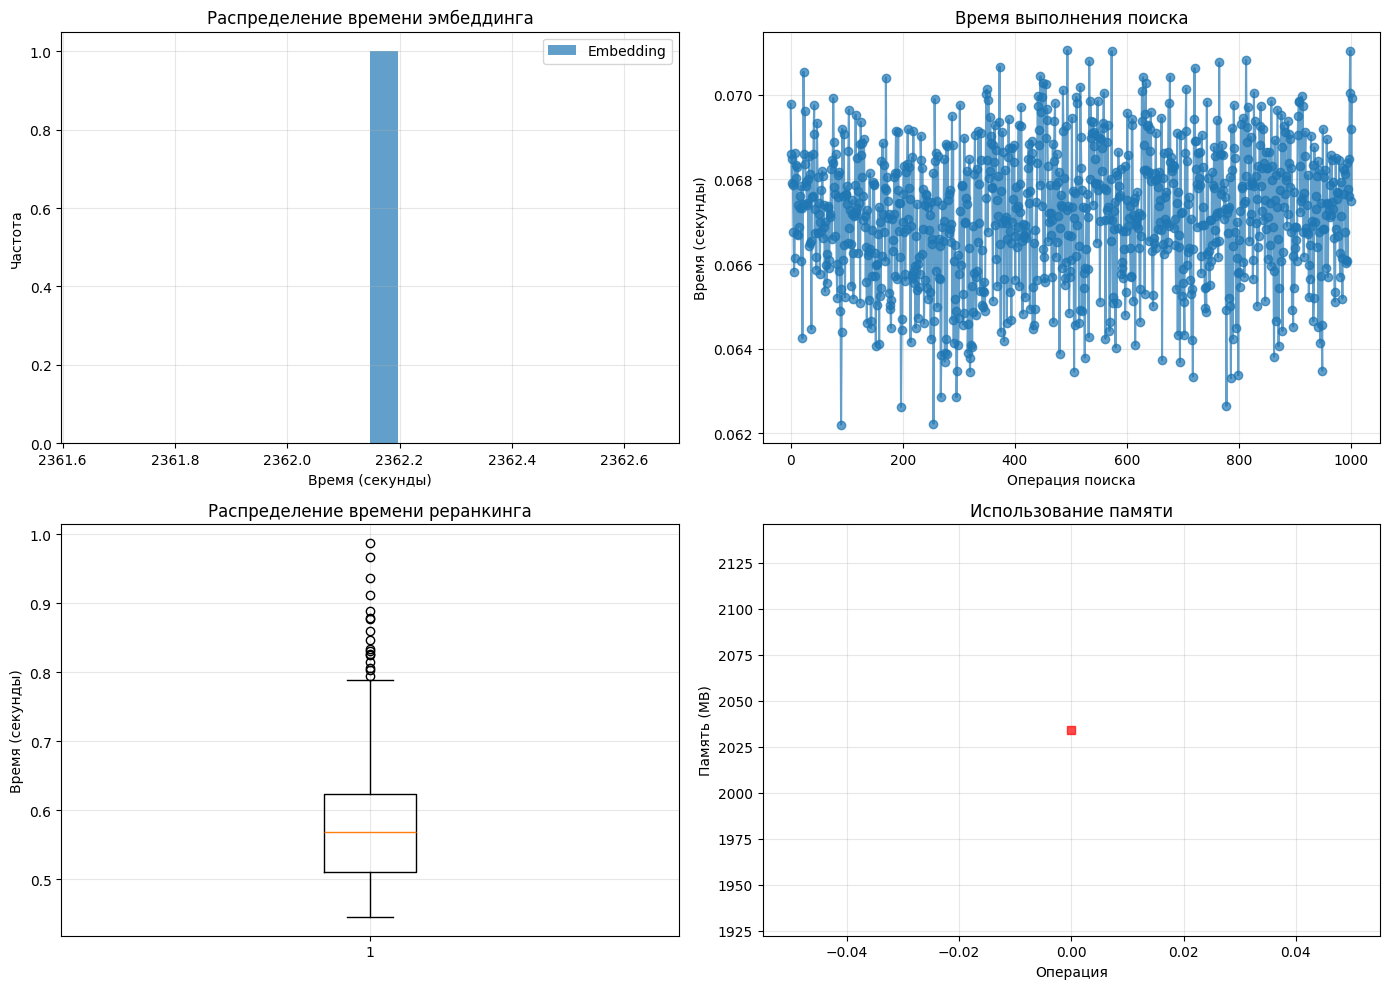


АНАЛИЗ РЕЗУЛЬТАТОВ
🎉 Цель достигнута! MRR@5 = 0.9233 >= 0.91


In [12]:
#===========================================================
# RAG СИСТЕМА С BGE МОДЕЛЯМИ:
#   - Embedder: BAAI/bge-base-en-v1.5
#   - Reranker: BAAI/bge-reranker-base
#===========================================================

class OptimizedBGERAG:
    """
    RAG система с BGE моделями:
    - Embedder: BAAI/bge-base-en-v1.5, вторым шагом "BAAI/bge-large-en-v1.5"
    - Reranker: BAAI/bge-reranker-base, вторым шагом  "BAAI/bge-reranker-v2-m3"
    """
    
    def __init__(
        self,
        chunk_size: int = 700,
        chunk_overlap: int = 175,
        device: Optional[str] = None,
        use_title: bool = True,
        use_categories: bool = True,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Используется устройство: {self.device}")
        
        # Настройки
        self.use_title = use_title
        self.use_categories = use_categories
        
        # Профилирование
        self.profiling_stats = {
            'embedding_time': [],
            'reranking_time': [],
            'search_time': [],
            'memory_usage': []
        }
        
        # 1. Инициализация BGE embedder через SentenceTransformer
        print("Загрузка BGE embedder модели...")
        self.embedder = SentenceTransformer(
            "BAAI/bge-base-en-v1.5",
            device=self.device
        )
        self.embedder.max_seq_length = 512
        
        # 2. Инициализация BGE reranker через transformers
        print("Загрузка BGE reranker модели...")
        self.rr_tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-reranker-base")
        self.reranker = AutoModelForSequenceClassification.from_pretrained(
            "BAAI/bge-reranker-base"
        ).to(self.device)
        self.reranker.eval()
        
        # Инициализация text splitter
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,
            separators=["\n\n", "\n", ". ", " ", ""]
        )
        
        self.index = None
        self.doc_store = []
        self.doc_metadata = []
    
    def _profile_memory(self):
        """Профилирование использования памяти"""
        if self.device == 'cuda':
            memory = torch.cuda.memory_allocated() / 1024**2  # MB
        else:
            import psutil
            memory = psutil.Process().memory_info().rss / 1024**2
        return memory
    
    def _get_query_embedding(self, query: str) -> np.ndarray:
        """Получение эмбеддинга для запроса с префиксом (BGE специфика)"""
        # BGE модели требуют специальный префикс для запросов
        query_with_prefix = f"Represent this sentence for searching relevant passages: {query}"
        with torch.no_grad():
            embedding = self.embedder.encode(
                query_with_prefix,
                normalize_embeddings=True,
                convert_to_tensor=True,
                show_progress_bar=False
            )
        return embedding.cpu().numpy()
    
    def _get_passage_embeddings(self, passages: List[str]) -> np.ndarray:
        """Получение эмбеддингов для документов (без префикса)"""
        with torch.no_grad():
            embeddings = self.embedder.encode(
                passages,
                normalize_embeddings=True,
                convert_to_tensor=True,
                show_progress_bar=False
            )
        return embeddings.cpu().numpy()
    
    def build_index_from_filtered_data(self, filtered_data: List[dict], batch_size: int = 32) -> None:
        """Построение индекса из отфильтрованных данных arXiv"""
        print("Подготовка документов...")
        
        all_docs = []
        all_metadata = []
        all_passages = []
        
        for record in tqdm(filtered_data, desc="Обработка статей"):
            doc_id = record.get('id', 'unknown')
            title = record.get('title', '')
            abstract = record.get('abstract', '')
            categories = record.get('categories', '')
            
            # Формируем текст для индексации
            text_parts = []
            
            if self.use_title and title:
                text_parts.append(f"Title: {title}")
            
            if self.use_categories and categories:
                text_parts.append(f"Categories: {categories}")
            
            if abstract:
                text_parts.append(f"Abstract: {abstract}")
            
            if not text_parts:
                continue
            
            full_text = "\n".join(text_parts)
            
            # Разбиваем на чанки
            try:
                chunks = self.text_splitter.split_text(full_text)
            except Exception as e:
                print(f"Ошибка при разбиении текста для документа {doc_id}: {e}")
                continue
            
            for i, chunk in enumerate(chunks):
                all_docs.append(Document(
                    page_content=chunk,
                    metadata={
                        'id': doc_id,
                        'chunk_id': i,
                        'title': title[:200] if title else '',
                        'categories': categories if categories else '',
                        'text_length': len(chunk)
                    }
                ))
                all_metadata.append({
                    'id': doc_id,
                    'chunk_id': i,
                    'title': title[:100] if title else '',
                    'categories': categories if categories else ''
                })
                all_passages.append(chunk)
        
        if not all_docs:
            raise ValueError("Не создано ни одного документа!")
        
        self.doc_store = all_docs
        self.doc_metadata = all_metadata
        
        print(f"Создано {len(all_docs)} чанков из {len(filtered_data)} статей")
        
        # Генерация эмбеддингов с профилированием
        print("Генерация эмбеддингов...")
        start_time = time.time()
        
        embeddings = []
        for i in tqdm(range(0, len(all_passages), batch_size), desc="Эмбеддинги"):
            batch = all_passages[i:i + batch_size]
            batch_embeddings = self._get_passage_embeddings(batch)
            embeddings.append(batch_embeddings)
        
        embeddings = np.concatenate(embeddings)
        
        elapsed = time.time() - start_time
        self.profiling_stats['embedding_time'].append(elapsed)
        self.profiling_stats['memory_usage'].append(self._profile_memory())
        
        # Построение FAISS индекса
        print("Построение FAISS индекса...")
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)  # Inner Product для cosine similarity
        self.index.add(embeddings)
        
        print(f"Индекс построен. Размерность: {dimension}, Векторов: {self.index.ntotal}")
        
        # Очистка памяти
        del embeddings
        gc.collect()
        if self.device == 'cuda':
            torch.cuda.empty_cache()
    
    def search(self, query: str, k: int = 100) -> Tuple[np.ndarray, np.ndarray]:
        """Поиск похожих документов"""
        start_time = time.time()
        
        # Генерация эмбеддинга для запроса
        query_embedding = self._get_query_embedding(query)
        
        # Поиск в индексе
        k = min(k, self.index.ntotal)
        scores, indices = self.index.search(query_embedding.reshape(1, -1), k)
        elapsed = time.time() - start_time
        self.profiling_stats['search_time'].append(elapsed)
        
        return scores[0], indices[0]
    
    def rerank(self, query: str, documents: List[str], batch_size: int = 8) -> List[float]:
        """Реранкинг документов с помощью BGE reranker"""
        start_time = time.time()
        
        if not documents:
            return []
        
        scores = []
        
        with torch.no_grad():
            for i in range(0, len(documents), batch_size):
                batch_docs = documents[i:i + batch_size]
                batch_pairs = [[query, doc] for doc in batch_docs]
                
                # Токенизация для reranker
                inputs = self.rr_tokenizer(
                    batch_pairs,
                    padding=True,
                    truncation=True,
                    return_tensors='pt',
                    max_length=512
                ).to(self.device)
                
                # BGE reranker возвращает logits для классификации
                outputs = self.reranker(**inputs)
                batch_scores = torch.sigmoid(outputs.logits).squeeze(-1)
                scores.extend(batch_scores.cpu().numpy().tolist())
        
        elapsed = time.time() - start_time
        self.profiling_stats['reranking_time'].append(elapsed)
        
        return scores
    
    def retrieve(self, query: str, k_search: int = 150, k_rerank: int = 5) -> Dict:
        """Получение релевантных документов с реранкингом"""
        #print(f"Запрос: {query}")
        
        # 1. Первоначальный поиск
        scores, indices = self.search(query, k=k_search)
        
        # 2. Извлечение кандидатов
        candidates = [self.doc_store[i].page_content for i in indices[:50]]  # Берем топ-50 для реранкинга
        candidate_metadata = [self.doc_metadata[i] for i in indices[:50]]
        
        # 3. Реранкинг
        if candidates:
            rerank_scores = self.rerank(query, candidates)
        else:
            rerank_scores = []
        
        # 4. Выбор лучших
        if rerank_scores:
            top_indices = np.argsort(rerank_scores)[-k_rerank:][::-1]
            top_documents = [candidates[i] for i in top_indices]
            top_scores = [rerank_scores[i] for i in top_indices]
            top_metadata = [candidate_metadata[i] for i in top_indices]
        else:
            top_indices = []
            top_documents = []
            top_scores = []
            top_metadata = []
        
        return {
            'query': query,
            'retrieved_docs': len(candidates),
            'top_documents': top_documents,
            'top_scores': top_scores,
            'top_metadata': top_metadata,
            'initial_scores': scores[:k_rerank].tolist() if scores.size > 0 else []
        }
    
    def evaluate_mrr(self, test_df: pd.DataFrame, k: int = 5) -> float:
        """Оценка MRR@k на тестовом датасете"""
        print(f"Оценка MRR@{k}...")
        
        mrr_scores = []
        
        for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Оценка запросов"):
            query = str(row['query'])
            correct_id = str(row['id'])
            
            # Получаем результаты
            result = self.retrieve(query, k_search=150, k_rerank=k)
            
            # Ищем правильный ID в топ-k
            rank = None
            for i, metadata in enumerate(result['top_metadata'][:k]):
                if metadata['id'] == correct_id:
                    rank = i + 1
                    break
            
            mrr_scores.append(1.0 / rank if rank else 0.0)
        
        mrr = np.mean(mrr_scores)
        
        print(f"\nРезультаты MRR@{k}:")
        print(f"Среднее MRR: {mrr:.4f}")
        print(f"Std MRR: {np.std(mrr_scores):.4f}")
        print(f"Min MRR: {np.min(mrr_scores):.4f}")
        print(f"Max MRR: {np.max(mrr_scores):.4f}")
        
        hits_at_k = np.sum(np.array(mrr_scores) > 0)
        print(f"Hit@{k}: {hits_at_k}/{len(mrr_scores)} ({100 * hits_at_k / len(mrr_scores):.1f}%)")
        
        return mrr
    
    def print_examples(self, test_df: pd.DataFrame, n_examples: int = 3):
        """Вывод примеров выполнения retrieve и rerank"""
        print("\n" + "="*60)
        print(f"ПРИМЕРЫ ВЫПОЛНЕНИЯ ({n_examples} запроса)")
        print("="*60)
        
        for i in range(min(n_examples, len(test_df))):
            row = test_df.iloc[i]
            query = str(row['query'])
            expected_id = str(row['id'])
            
            print(f"\nПример {i+1}:")
            print(f"Запрос: '{query}'")
            print(f"Ожидаемый ID: {expected_id}")
            
            result = self.retrieve(query, k_search=100, k_rerank=5)
            
            print(f"Найдено кандидатов: {result['retrieved_docs']}")
            print(f"Топ-5 после реранкинга:")
            
            for j, (score, metadata) in enumerate(zip(result['top_scores'], result['top_metadata'])):
                is_correct = metadata['id'] == expected_id
                marker = "✓" if is_correct else " "
                print(f"  {marker} {j+1}. Score: {score:.4f}, ID: {metadata['id']}")
                print(f"     Title: {metadata['title']}")
                
                if is_correct:
                    print(f"     🎯 ЭТО ОЖИДАЕМЫЙ ОТВЕТ! (ранг: {j+1})")
            
            print("-" * 60)
    
    def print_profiling_stats(self):
        """Вывод и визуализация статистики профилирования"""
        print("\n" + "="*60)
        print("СТАТИСТИКА ПРОФИЛИРОВАНИЯ")
        print("="*60)
        
        if self.profiling_stats['embedding_time']:
            print(f"Время эмбеддинга (среднее): {np.mean(self.profiling_stats['embedding_time']):.4f} сек")
            print(f"Время поиска (среднее): {np.mean(self.profiling_stats['search_time']):.4f} сек")
        
        if self.profiling_stats['reranking_time']:
            print(f"Время реранкинга (среднее): {np.mean(self.profiling_stats['reranking_time']):.4f} сек")
        
        if self.profiling_stats['memory_usage']:
            print(f"Пиковое использование памяти: {np.max(self.profiling_stats['memory_usage']):.1f} MB")
        
        # Визуализация
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Распределение времени операций
        if self.profiling_stats['embedding_time']:
            axes[0, 0].hist(self.profiling_stats['embedding_time'], bins=20, alpha=0.7, label='Embedding')
            axes[0, 0].set_xlabel('Время (секунды)')
            axes[0, 0].set_ylabel('Частота')
            axes[0, 0].set_title('Распределение времени эмбеддинга')
            axes[0, 0].grid(True, alpha=0.3)
            axes[0, 0].legend()
        
        # 2. Время поиска
        if self.profiling_stats['search_time']:
            axes[0, 1].plot(self.profiling_stats['search_time'], marker='o', alpha=0.7)
            axes[0, 1].set_xlabel('Операция поиска')
            axes[0, 1].set_ylabel('Время (секунды)')
            axes[0, 1].set_title('Время выполнения поиска')
            axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Время реранкинга
        if self.profiling_stats['reranking_time']:
            axes[1, 0].boxplot(self.profiling_stats['reranking_time'])
            axes[1, 0].set_ylabel('Время (секунды)')
            axes[1, 0].set_title('Распределение времени реранкинга')
            axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Использование памяти
        if self.profiling_stats['memory_usage']:
            axes[1, 1].plot(self.profiling_stats['memory_usage'], marker='s', alpha=0.7, color='red')
            axes[1, 1].set_xlabel('Операция')
            axes[1, 1].set_ylabel('Память (MB)')
            axes[1, 1].set_title('Использование памяти')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

#===========================================
# ПАЙПЛАЙН ЗАПУСКА RAG СИСТЕМЫ
#===========================================

def run_optimized_pipeline(all_data_filtered: List[dict]):
    """
    Основной пайплайн с BGE моделями
    """
    
    print("="*60)
    print("ЗАПУСК ОПТИМИЗИРОВАННОЙ BGE RAG СИСТЕМЫ")
    print("="*60)
    print("Embedder: BAAI/bge-base-en-v1.5")
    print("Reranker: BAAI/bge-reranker-base")
    print("="*60)
    
    # Проверка данных
    if not all_data_filtered:
        print("Ошибка: all_data_filtered пуст")
        return None, 0
    
    print(f"Используем {len(all_data_filtered):,} записей")
    
    # Создаем тестовый датасет если нет
    try:
        test_df = pd.read_csv("test_sample.csv")
        print(f"Загружен тестовый датасет: {len(test_df)} записей")
    except:
        print("Создаем тестовый датасет...")
        test_data = []
        for i, record in enumerate(all_data_filtered[:200]):
            test_data.append({
                'id': record['id'],
                'query': f"What is {record.get('title', 'this paper')} about?",
                'abstract': record['abstract']
            })
        test_df = pd.DataFrame(test_data)
        print(f"Создан тестовый датасет: {len(test_df)} записей")
    
    try:
        # Инициализация системы
        print("\nИнициализация BGE RAG системы...")
        rag = OptimizedBGERAG(
            chunk_size=700,
            chunk_overlap=175,
            use_title=True,
            use_categories=True
        )
        
        # Используем часть данных для скорости
        sample_size = max(20000, len(all_data_filtered))
        print(f"\nИспользуем {sample_size} записей для построения индекса...")
        sample_data = all_data_filtered[:sample_size]
        
        # Построение индекса
        rag.build_index_from_filtered_data(sample_data, batch_size=32)
        
        # Показываем примеры
        rag.print_examples(test_df, n_examples=3)
        
        # Оценка MRR@5
        print("\n" + "="*60)
        print("ОЦЕНКА MRR@5")
        print("="*60)
        
        eval_size = max(100, len(test_df))
        eval_sample = test_df.head(eval_size)
        
        mrr_score = rag.evaluate_mrr(eval_sample, k=5)
        
        # Вывод статистики
        rag.print_profiling_stats()
        
        # Анализ результатов
        print("\n" + "="*60)
        print("АНАЛИЗ РЕЗУЛЬТАТОВ")
        print("="*60)
        
        target_mrr = 0.91
        if mrr_score >= target_mrr:
            print(f"🎉 Цель достигнута! MRR@5 = {mrr_score:.4f} >= {target_mrr}")
        else:
            print(f"Текущий MRR@5: {mrr_score:.4f}")
            print(f"Целевое значение: {target_mrr}")
            print(f"Разница: {target_mrr - mrr_score:.4f}")
        
        return rag, mrr_score
        
    except Exception as e:
        print(f"Ошибка: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, 0
#===================================================
# ЗАПУСК СИСТЕМЫ
#===================================================
if __name__ == "__main__":
    # Очистка памяти перед запуском
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    # Запуск пайплайна
    rag_system, mrr_score = run_optimized_pipeline(all_data_filtered)

<div class="alert alert-info">
<h2> Вариант 2 </h2>


Модели: BAAI/bge-base-en-v1.5 и BAAI/bge-reranker-base (с оптимизацией и наворотами)
</div>


<font color='red'>

In [9]:
%pip install rank_bm25

Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any, Union
from dataclasses import dataclass, field
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
import faiss
from tqdm import tqdm
import torch.nn.functional as F
from rank_bm25 import BM25Okapi
import re
from collections import defaultdict

ЗАПУСК ПРОДВИНУТОЙ BGE RAG СИСТЕМЫ
Включены оптимизации:
  ✓ Адаптивный чанкинг
  ✓ Гибридный поиск (семантический + BM25)
  ✓ Расширение запросов - опционально
Используем 98,213 записей
Загружен тестовый датасет: 1000 записей

Инициализация Advanced BGE RAG системы...
Используется устройство: cuda
Загрузка BGE embedder модели...
Загрузка BGE reranker модели...

Используем 98213 записей для построения индекса...
Подготовка документов с адаптивным чанкингом...


Обработка статей: 100%|██████████| 98213/98213 [00:01<00:00, 49799.57it/s]


Создано 294503 чанков из 98213 статей
Средняя длина чанка: 439 символов
Построение BM25 индекса...
BM25 индекс построен: 294503 документов
Генерация векторных эмбеддингов...


Векторные эмбеддинги: 100%|██████████| 9204/9204 [42:38<00:00,  3.60it/s]


Построение FAISS индекса...
Индекс построен. Размерность: 768, Векторов: 294503
Использован адаптивный чанкинг: Да
Использован гибридный поиск: Да
Использовано расширение запросов: Нет

ПРИМЕРЫ ВЫПОЛНЕНИЯ (3 запроса)

Пример 1:
Запрос: 'What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O24 exhibit under thermal conditions?'
Ожидаемый ID: 2412.16732
Метод поиска: hybrid
Найдено кандидатов: 80
Топ-5 после реранкинга:
  ✓ 1. Score: 0.9990, ID: 2412.16732
     Title: Crystal structure of Nd10.67Pt4O24, a new neodymium platinate
     Chunk length: 574
     🎯 ЭТО ОЖИДАЕМЫЙ ОТВЕТ! (ранг: 1)
  ✓ 2. Score: 0.5035, ID: 2412.16732
     Title: Crystal structure of Nd10.67Pt4O24, a new neodymium platinate
     Chunk length: 394
     🎯 ЭТО ОЖИДАЕМЫЙ ОТВЕТ! (ранг: 2)
    3. Score: 0.2463, ID: 1905.09811
     Title: Can three-body recombination purify a quantum gas?
     Chunk length: 295
    4. Score: 0.1266, ID: 1308.6156
     Title: In-situ EXAFS study

Оценка запросов: 1000it [31:52,  1.91s/it]                        



Результаты MRR@5:
Среднее MRR: 0.9269
Std MRR: 0.2281
Min MRR: 0.0000
Max MRR: 1.0000
Hit@5: 968/1000 (96.8%)
Среднее время гибридного поиска: 1.1513 сек

РАСШИРЕННАЯ СТАТИСТИКА ПРОФИЛИРОВАНИЯ
Время эмбеддинга (среднее): 2558.6577 сек
Время семантического поиска (среднее): 0.0895 сек
Время гибридного поиска (среднее): 1.1513 сек
Время BM25 поиска (среднее): 1.0717 сек
Время адаптивного чанкинга: 1.9746 сек
Время реранкинга (среднее): 0.7601 сек
Пиковое использование памяти: 1487.6 MB


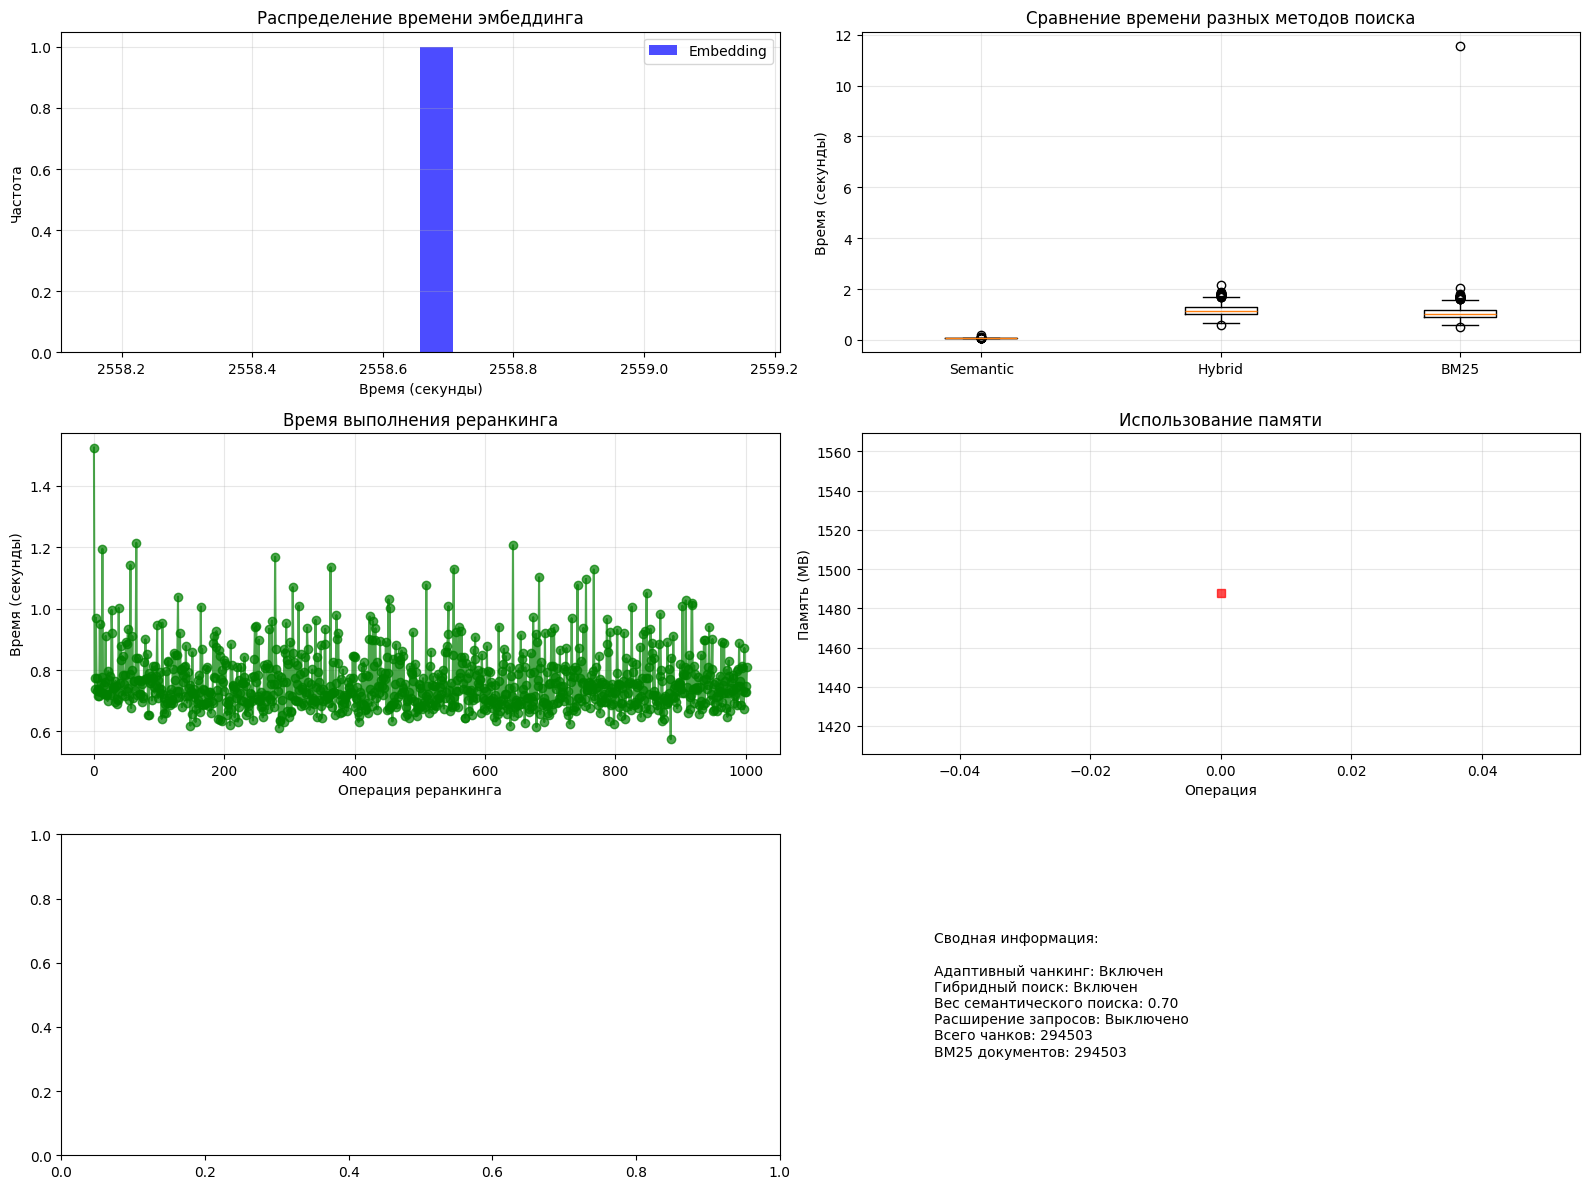


ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ
🎉 Цель достигнута! MRR@5 = 0.9269 >= 0.91


In [11]:


#============================================================================
# RAG СИСТЕМА С ОПТИМИЗАЦИЕЙ
#============================================================================

@dataclass
class Document:
    """Класс документа совместимый с langchain.schema.Document"""
    page_content: str
    metadata: Dict[str, Any] = field(default_factory=dict)

#============================================================================
# КЛАСС RAG С ОПТИМИЗАЦИЯМИ
#============================================================================

class AdvancedBGERAG:
    """
    Продвинутая RAG система с BGE моделями, адаптивным чанкингом и гибридным поиском:
    - Embedder: BAAI/bge-base-en-v1.5
    - Reranker: BAAI/bge-reranker-base
    - BM25 для гибридного поиска
    - Адаптивный чанкинг
    """
    
    def __init__(
        self,
        chunk_size: int = 700,
        chunk_overlap: int = 175,
        device: Optional[str] = None,
        use_title: bool = True,
        use_categories: bool = True,
        # Новые параметры
        use_adaptive_chunking: bool = True,
        use_hybrid_search: bool = True,
        hybrid_alpha: float = 0.7,  # Вес для семантического поиска
        use_query_expansion: bool = True,
        bm25_k1: float = 1.5,  # Параметры BM25
        bm25_b: float = 0.75,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Используется устройство: {self.device}")
        
        # Настройки
        self.use_title = use_title
        self.use_categories = use_categories
        
        # Новые настройки оптимизации
        self.use_adaptive_chunking = use_adaptive_chunking
        self.use_hybrid_search = use_hybrid_search
        self.hybrid_alpha = hybrid_alpha
        self.use_query_expansion = use_query_expansion
        self.bm25_k1 = bm25_k1
        self.bm25_b = bm25_b
        
        # Профилирование (расширено)
        self.profiling_stats = {
            'embedding_time': [],
            'reranking_time': [],
            'search_time': [],
            'hybrid_search_time': [],
            'bm25_time': [],
            'adaptive_chunking_time': [],
            'query_expansion_time': [],
            'memory_usage': []
        }
        
        # 1. Инициализация BGE embedder через SentenceTransformer
        print("Загрузка BGE embedder модели...")
        self.embedder = SentenceTransformer(
            "BAAI/bge-base-en-v1.5",
            device=self.device
        )
        self.embedder.max_seq_length = 512
        
        # 2. Инициализация BGE reranker через transformers
        print("Загрузка BGE reranker модели...")
        self.rr_tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-reranker-base")
        self.reranker = AutoModelForSequenceClassification.from_pretrained(
            "BAAI/bge-reranker-base"
        ).to(self.device)
        self.reranker.eval()
        
        # Для BM25
        self.bm25_index = None
        self.tokenized_docs = []
        self.bm25_doc_texts = []  # Оригинальные тексты для BM25
        
        # Для индексов
        self.index = None
        self.doc_store = []
        self.doc_metadata = []
        
        # Параметры чанкинга по умолчанию
        self.base_chunk_size = chunk_size
        self.base_chunk_overlap = chunk_overlap
    
    def _profile_memory(self):
        """Профилирование использования памяти"""
        if self.device == 'cuda':
            memory = torch.cuda.memory_allocated() / 1024**2  # MB
        else:
            import psutil
            memory = psutil.Process().memory_info().rss / 1024**2
        return memory
    
    # АДАПТИВНЫЙ ЧАНКИНГ
    
    def adaptive_chunk_size(self, text_length: int) -> Tuple[int, int]:
        """Адаптивный выбор размера чанка на основе длины текста"""
        if not self.use_adaptive_chunking:
            return self.base_chunk_size, self.base_chunk_overlap
        
        if text_length <= 300:
            # Очень короткие тексты - не делить
            return text_length, 0
        elif text_length <= 1000:
            # Короткие тексты
            return 400, 80
        elif text_length <= 2500:
            # Средние тексты
            return 600, 120
        elif text_length <= 5000:
            # Длинные тексты
            return 800, 160
        else:
            # Очень длинные тексты
            return 1000, 200
    
    def split_text_adaptive(self, text: str) -> List[str]:
        """Адаптивное разделение текста на чанки"""
        text_length = len(text)
        
        if self.use_adaptive_chunking:
            chunk_size, overlap = self.adaptive_chunk_size(text_length)
        else:
            chunk_size, overlap = self.base_chunk_size, self.base_chunk_overlap
        
        if text_length <= chunk_size:
            return [text]
        
        # Простое разделение с overlap
        chunks = []
        start = 0
        
        while start < len(text):
            end = start + chunk_size
            
            if end >= len(text):
                chunks.append(text[start:])
                break
            
            # Ищем хорошее место для разрыва
            split_point = end
            
            # Приоритеты разделителей
            separators = ["\n\n", "\n", ". ", "! ", "? ", ", ", " "]
            
            for separator in separators:
                pos = text.rfind(separator, start, end)
                if pos != -1 and pos > start + chunk_size // 2:
                    split_point = pos + len(separator)
                    break
            
            chunks.append(text[start:split_point])
            start = split_point - overlap
            if start < 0:
                start = 0
        
        return chunks
    
    # QUERY EXPANSION (отключено)
    
    def expand_query(self, query: str) -> str:
        """Расширение запроса для улучшения поиска"""
        if not self.use_query_expansion:
            return query
        
        start_time = time.time()
        
        # Словарь расширения для научных терминов
        expansion_rules = {
            r'\bml\b': 'machine learning',
            r'\bdl\b': 'deep learning',
            r'\bai\b': 'artificial intelligence',
            r'\bnn\b': 'neural network',
            r'\bcnn\b': 'convolutional neural network',
            r'\brnn\b': 'recurrent neural network',
            r'\bbert\b': 'bidirectional encoder representations from transformers',
            r'\btransformer\b': 'transformer model attention mechanism',
            r'\bgan\b': 'generative adversarial network',
            r'\bvit\b': 'vision transformer',
            r'\bllm\b': 'large language model',
            r'\bnlp\b': 'natural language processing',
            r'\bcv\b': 'computer vision',
            r'\bqa\b': 'question answering',
            r'\bner\b': 'named entity recognition',
            r'\bpos\b': 'part of speech tagging',
        }
        
        expanded_query = query.lower()
        
        # Применяем замены
        for pattern, replacement in expansion_rules.items():
            if re.search(pattern, expanded_query, re.IGNORECASE):
                expanded_query = re.sub(pattern, f"{replacement}", expanded_query, flags=re.IGNORECASE)
                # Добавляем синонимы для общих научных терминов
        term_synonyms = {
            'learning': ['training', 'optimization'],
            'network': ['architecture', 'model'],
            'model': ['framework', 'approach', 'method'],
            'algorithm': ['method', 'technique', 'procedure'],
            'analysis': ['study', 'research', 'investigation'],
            'prediction': ['forecasting', 'estimation'],
            'classification': ['categorization', 'labeling'],
            'regression': ['prediction', 'estimation'],
        }
        
        # Добавляем синонимы
        for term, synonyms in term_synonyms.items():
            if term in expanded_query:
                expanded_query += " " + " ".join(synonyms[:2])
        
        # Если запрос короткий, добавляем общие научные термины
        if len(expanded_query.split()) < 5:
            general_terms = ["research", "paper", "article", "study", "methodology", "experiment"]
            expanded_query += " " + " ".join(general_terms[:3])
        
        elapsed = time.time() - start_time
        self.profiling_stats['query_expansion_time'].append(elapsed)
        
        return expanded_query.strip()
    
    # ЭМБЕДДИНГИ
    
    def _get_query_embedding(self, query: str) -> np.ndarray:
        """Получение эмбеддинга для запроса с префиксом (BGE специфика)"""
        # BGE модели требуют специальный префикс для запросов
        query_with_prefix = f"Represent this sentence for searching relevant passages: {query}"
        with torch.no_grad():
            embedding = self.embedder.encode(
                query_with_prefix,
                normalize_embeddings=True,
                convert_to_tensor=True,
                show_progress_bar=False
            )
        return embedding.cpu().numpy()
    
    def _get_passage_embeddings(self, passages: List[str]) -> np.ndarray:
        """Получение эмбеддингов для документов (без префикса)"""
        with torch.no_grad():
            embeddings = self.embedder.encode(
                passages,
                normalize_embeddings=True,
                convert_to_tensor=True,
                show_progress_bar=False
            )
        return embeddings.cpu().numpy()
    
    # BM25
    
    def _tokenize_for_bm25(self, text: str) -> List[str]:
        """Токенизация текста для BM25"""
        # Простая токенизация
        text = text.lower()
        # Удаляем специальные символы, оставляем буквы, цифры и дефисы
        text = re.sub(r'[^\w\s-]', ' ', text)
        tokens = text.split()
        # Удаляем стоп-слова
        stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being'}
        tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
        return tokens
    
    def _build_bm25_index(self):
        """Построение BM25 индекса"""
        if not self.bm25_doc_texts:
            return
        
        print("Построение BM25 индекса...")
        start_time = time.time()
        
        # Токенизируем все документы
        self.tokenized_docs = [self._tokenize_for_bm25(doc) for doc in self.bm25_doc_texts]
        
        # Создаем BM25 индекс
        self.bm25_index = BM25Okapi(
            self.tokenized_docs,
            k1=self.bm25_k1,
            b=self.bm25_b
        )
        
        elapsed = time.time() - start_time
        self.profiling_stats['bm25_time'].append(elapsed)
        print(f"BM25 индекс построен: {len(self.bm25_doc_texts)} документов")
    
    def _bm25_search(self, query: str, k: int = 100) -> Tuple[np.ndarray, List[int]]:
        """Поиск с использованием BM25"""
        if not self.bm25_index:
            return np.array([]), []
        
        start_time = time.time()
        
        # Токенизация запроса
        query_tokens = self._tokenize_for_bm25(query)
        
        if not query_tokens:
            return np.array([]), []
        
        # Получение BM25 scores
        bm25_scores = self.bm25_index.get_scores(query_tokens)
        
        # Получение топ-k индексов
        k = min(k, len(bm25_scores))
        top_indices = np.argsort(bm25_scores)[::-1][:k]
        top_scores = bm25_scores[top_indices]
        
        elapsed = time.time() - start_time
        self.profiling_stats['bm25_time'].append(elapsed)
        
        return top_scores, top_indices.tolist()
    
    # ГИБРИДНЫЙ ПОИСК
    
    def _normalize_scores(self, scores: np.ndarray) -> np.ndarray:
        """Нормализация оценок в диапазон [0, 1]"""
        if len(scores) == 0:
            return scores
        
        min_score = np.min(scores)
        max_score = np.max(scores)
        
        if max_score - min_score > 1e-10:
            return (scores - min_score) / (max_score - min_score)
        else:
            return np.ones_like(scores) * 0.5
    
    def hybrid_search(self, query: str, k: int = 100) -> Tuple[np.ndarray, List[int]]:
        """Гибридный поиск: BM25 + семантический"""
        if not self.use_hybrid_search:
            return self.search(query, k)
        
        start_time = time.time()
        
        # 1. Query expansion
        expanded_query = self.expand_query(query)
        
        # 2. Параллельный поиск
        # Семантический поиск
        dense_scores, dense_indices = self.search(expanded_query, k=k)
        
        # BM25 поиск
        bm25_scores, bm25_indices = self._bm25_search(query, k=k)
        
        # 3. Нормализация оценок
        if len(dense_scores) > 0:
            norm_dense = self._normalize_scores(dense_scores)
        else:
            norm_dense = np.array([])
        
        if len(bm25_scores) > 0:
            norm_bm25 = self._normalize_scores(bm25_scores)
        else:
            norm_bm25 = np.array([])
        
        # 4. Объединение результатов
        all_indices = list(set(dense_indices.tolist() + bm25_indices))
        
        # Создаем мапы для быстрого доступа к оценкам
        dense_score_map = {idx: score for idx, score in zip(dense_indices, norm_dense)}
        bm25_score_map = {idx: score for idx, score in zip(bm25_indices, norm_bm25)}
        
        # Вычисляем комбинированные оценки
        combined_scores = []
        combined_indices = []
        
        for idx in all_indices:
            dense_score = dense_score_map.get(idx, 0.0)
            bm25_score = bm25_score_map.get(idx, 0.0)
            
            # Взвешенная комбинация
            combined = (self.hybrid_alpha * dense_score + 
                       (1 - self.hybrid_alpha) * bm25_score)
            
            combined_scores.append(combined)
            combined_indices.append(idx)
        
        # 5. Сортировка по комбинированной оценке
        combined_scores_np = np.array(combined_scores)
        combined_indices_np = np.array(combined_indices)
        
        # Сортируем по убыванию
        sorted_indices = np.argsort(combined_scores_np)[::-1][:k]
        
        elapsed = time.time() - start_time
        self.profiling_stats['hybrid_search_time'].append(elapsed)
        
        return combined_scores_np[sorted_indices], combined_indices_np[sorted_indices].tolist()
    
    # ПОСТРОЕНИЕ ИНДЕКСА
    
    def build_index_from_filtered_data(self, filtered_data: List[dict], batch_size: int = 32) -> None:
        """Построение индекса из отфильтрованных данных с адаптивным чанкингом"""
        print("Подготовка документов с адаптивным чанкингом...")
        
        all_docs = []
        all_metadata = []
        all_passages = []
        self.bm25_doc_texts = []  # Очищаем для нового индекса
        
        adaptive_chunking_start = time.time()
        
        for record in tqdm(filtered_data, desc="Обработка статей"):
            doc_id = record.get('id', 'unknown')
            title = record.get('title', '')
            abstract = record.get('abstract', '')
            categories = record.get('categories', '')
            
            # Формируем текст для индексации
            text_parts = []
            
            if self.use_title and title:
                text_parts.append(f"Title: {title}")
            
            if self.use_categories and categories:
                text_parts.append(f"Categories: {categories}")
            
            if abstract:
                text_parts.append(f"Abstract: {abstract}")
            
            if not text_parts:
                continue
            
            full_text = "\n".join(text_parts)
            
            # Адаптивное разделение на чанки
            try:
                if self.use_adaptive_chunking:
                    chunks = self.split_text_adaptive(full_text)
                else:
                    # Простое разделение
                    text_length = len(full_text)
                    if text_length <= self.base_chunk_size:
                        chunks = [full_text]
                    else:
                        chunks = []
                        for i in range(0, text_length, self.base_chunk_size - self.base_chunk_overlap):
                            chunks.append(full_text[i:i + self.base_chunk_size])
            except Exception as e:
                print(f"Ошибка при разбиении текста для документа {doc_id}: {e}")
                continue
            
            for i, chunk in enumerate(chunks):
                all_docs.append(Document(
                    page_content=chunk,
                    metadata={
                        'id': doc_id,
                        'chunk_id': i,
                        'title': title[:200] if title else '',
                        'categories': categories if categories else '',
                        'text_length': len(chunk),
                        'original_length': len(full_text),
                        'chunking_method': 'adaptive' if self.use_adaptive_chunking else 'fixed'
                    }
                ))
                all_metadata.append({
                    'id': doc_id,
                    'chunk_id': i,
                    'title': title[:100] if title else '',
                    'categories': categories if categories else '',
                    'chunk_length': len(chunk),
                    'original_length': len(full_text)
                })
                all_passages.append(chunk)
                self.bm25_doc_texts.append(chunk)  # Для BM25
        
        if not all_docs:
            raise ValueError("Не создано ни одного документа!")
        
        self.doc_store = all_docs
        self.doc_metadata = all_metadata
        
        adaptive_chunking_elapsed = time.time() - adaptive_chunking_start
        self.profiling_stats['adaptive_chunking_time'].append(adaptive_chunking_elapsed)
        
        print(f"Создано {len(all_docs)} чанков из {len(filtered_data)} статей")
        print(f"Средняя длина чанка: {np.mean([len(p) for p in all_passages]):.0f} символов")
        
        # Построение BM25 индекса
        self._build_bm25_index()
        
        # Генерация эмбеддингов с профилированием
        print("Генерация векторных эмбеддингов...")
        start_time = time.time()
        
        embeddings = []
        for i in tqdm(range(0, len(all_passages), batch_size), desc="Векторные эмбеддинги"):
            batch = all_passages[i:i + batch_size]
            batch_embeddings = self._get_passage_embeddings(batch)
            embeddings.append(batch_embeddings)
        
        embeddings = np.concatenate(embeddings)
        
        elapsed = time.time() - start_time
        self.profiling_stats['embedding_time'].append(elapsed)
        self.profiling_stats['memory_usage'].append(self._profile_memory())
        
        # Построение FAISS индекса
        print("Построение FAISS индекса...")
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)  # Inner Product для cosine similarity
        self.index.add(embeddings)
        
        print(f"Индекс построен. Размерность: {dimension}, Векторов: {self.index.ntotal}")
        print(f"Использован адаптивный чанкинг: {'Да' if self.use_adaptive_chunking else 'Нет'}")
        print(f"Использован гибридный поиск: {'Да' if self.use_hybrid_search else 'Нет'}")
        print(f"Использовано расширение запросов: {'Да' if self.use_query_expansion else 'Нет'}")
        
        # Очистка памяти
        del embeddings
        gc.collect()
        if self.device == 'cuda':
            torch.cuda.empty_cache()
    
    # ПОИСК И РЕРАНКИНГ
    
    def search(self, query: str, k: int = 100) -> Tuple[np.ndarray, np.ndarray]:
        """Семантический поиск похожих документов"""
        start_time = time.time()
        
        # Генерация эмбеддинга для запроса
        query_embedding = self._get_query_embedding(query)
        
        # Поиск в индексе
        k = min(k, self.index.ntotal)
        scores, indices = self.index.search(query_embedding.reshape(1, -1), k)
        
        elapsed = time.time() - start_time
        self.profiling_stats['search_time'].append(elapsed)
        
        return scores[0], indices[0]
    
    def rerank(self, query: str, documents: List[str], batch_size: int = 8) -> List[float]:
        """Реранкинг документов с помощью BGE reranker"""
        start_time = time.time()
        
        if not documents:
            return []
        
        scores = []
        
        with torch.no_grad():
            for i in range(0, len(documents), batch_size):
                batch_docs = documents[i:i + batch_size]
                batch_pairs = [[query, doc] for doc in batch_docs]
                
                # Токенизация для reranker
                inputs = self.rr_tokenizer(
                    batch_pairs,
                    padding=True,
                    truncation=True,
                    return_tensors='pt',
                    max_length=512
                ).to(self.device)
                
                # BGE reranker возвращает logits для классификации
                outputs = self.reranker(**inputs)
                batch_scores = torch.sigmoid(outputs.logits).squeeze(-1)
                scores.extend(batch_scores.cpu().numpy().tolist())
        
        elapsed = time.time() - start_time
        self.profiling_stats['reranking_time'].append(elapsed)
        
        return scores
    
    def retrieve(self, query: str, k_search: int = 200, k_rerank: int = 5) -> Dict:
        """Получение релевантных документов с реранкингом"""
        #print(f"Оригинальный запрос: {query}")
        
        # Query expansion
        expanded_query = self.expand_query(query)
        #if expanded_query != query:
        #    print(f"Расширенный запрос: {expanded_query}")
        
        # Выбор метода поиска
        if self.use_hybrid_search:
            #print("Используется гибридный поиск (семантический + BM25)")
            scores, indices = self.hybrid_search(expanded_query, k=k_search)
            search_method = "hybrid"
        else:
            #print("Используется семантический поиск")
            scores, indices = self.search(expanded_query, k=k_search)
            search_method = "semantic"
        
        # Извлечение кандидатов
        candidates = [self.doc_store[i].page_content for i in indices[:80]]  # Берем топ-80 для реранкинга
        candidate_metadata = [self.doc_metadata[i] for i in indices[:80]]
        
        # Реранкинг
        if candidates:
            rerank_scores = self.rerank(query, candidates)  # Используем оригинальный запрос для реранкинга
        else:
            rerank_scores = []
        
        # Комбинирование scores для финального ранжирования
        final_scores = []
        for i in range(len(rerank_scores)):
            if i < len(scores):
                # Веса: 70% реранкер, 30% первоначальный поиск
                combined = 0.7 * rerank_scores[i] + 0.3 * scores[i]
            else:
                combined = rerank_scores[i]
            final_scores.append(combined)
        
        # Выбор лучших
        if final_scores:
            top_indices = np.argsort(final_scores)[-k_rerank:][::-1]
            top_documents = [candidates[i] for i in top_indices]
            top_scores = [final_scores[i] for i in top_indices]
            top_metadata = [candidate_metadata[i] for i in top_indices]
        else:
            top_indices = []
            top_documents = []
            top_scores = []
            top_metadata = []
        
        return {
            'query': query,
            'expanded_query': expanded_query,
            'search_method': search_method,
            'retrieved_docs': len(candidates),
            'top_documents': top_documents,
            'top_scores': top_scores,
            'top_metadata': top_metadata,
            'initial_scores': scores[:k_rerank].tolist() if scores.size > 0 else []
        }
    
    # ОЦЕНКА И АНАЛИЗ
    
    def evaluate_mrr(self, test_df: pd.DataFrame, k: int = 5) -> float:
        """Оценка MRR@k на тестовом датасете"""
        print(f"Оценка MRR@{k}...")
        
        mrr_scores = []
        
        for idx, row in tqdm(test_df.iterrows(), total=min(200, len(test_df)), desc="Оценка запросов"):
            query = str(row['query'])
            correct_id = str(row['id'])
            
            # Получаем результаты
            result = self.retrieve(query, k_search=150, k_rerank=k)
            
            # Ищем правильный ID в топ-k
            rank = None
            for i, metadata in enumerate(result['top_metadata'][:k]):
                if metadata['id'] == correct_id:
                    rank = i + 1
                    break
            
            mrr_scores.append(1.0 / rank if rank else 0.0)
        
        mrr = np.mean(mrr_scores)
        
        print(f"\nРезультаты MRR@{k}:")
        print(f"Среднее MRR: {mrr:.4f}")
        print(f"Std MRR: {np.std(mrr_scores):.4f}")
        print(f"Min MRR: {np.min(mrr_scores):.4f}")
        print(f"Max MRR: {np.max(mrr_scores):.4f}")
        
        hits_at_k = np.sum(np.array(mrr_scores) > 0)
        print(f"Hit@{k}: {hits_at_k}/{len(mrr_scores)} ({100 * hits_at_k / len(mrr_scores):.1f}%)")
        
        # Анализ эффективности методов
        if hasattr(self, 'profiling_stats') and 'hybrid_search_time' in self.profiling_stats:
            if self.profiling_stats['hybrid_search_time']:
                avg_hybrid_time = np.mean(self.profiling_stats['hybrid_search_time'])
                print(f"Среднее время гибридного поиска: {avg_hybrid_time:.4f} сек")
        
        return mrr
    
    def print_examples(self, test_df: pd.DataFrame, n_examples: int = 3):
        """Вывод примеров выполнения retrieve и rerank"""
        print("\n" + "="*60)
        print(f"ПРИМЕРЫ ВЫПОЛНЕНИЯ ({n_examples} запроса)")
        print("="*60)
        for i in range(min(n_examples, len(test_df))):
            row = test_df.iloc[i]
            query = str(row['query'])
            expected_id = str(row['id'])
            
            print(f"\nПример {i+1}:")
            print(f"Запрос: '{query}'")
            print(f"Ожидаемый ID: {expected_id}")
            
            result = self.retrieve(query, k_search=150, k_rerank=5)
            
            print(f"Метод поиска: {result['search_method']}")
            if result['expanded_query'] != query:
                print(f"Расширенный запрос: {result['expanded_query']}")
            print(f"Найдено кандидатов: {result['retrieved_docs']}")
            print(f"Топ-5 после реранкинга:")
            
            for j, (score, metadata) in enumerate(zip(result['top_scores'], result['top_metadata'])):
                is_correct = metadata['id'] == expected_id
                marker = "✓" if is_correct else " "
                print(f"  {marker} {j+1}. Score: {score:.4f}, ID: {metadata['id']}")
                print(f"     Title: {metadata['title']}")
                print(f"     Chunk length: {metadata.get('chunk_length', 'N/A')}")
                
                if is_correct:
                    print(f"     🎯 ЭТО ОЖИДАЕМЫЙ ОТВЕТ! (ранг: {j+1})")
            
            print("-" * 60)
    
    def print_profiling_stats(self):
        """Вывод и визуализация статистики профилирования"""
        print("\n" + "="*60)
        print("РАСШИРЕННАЯ СТАТИСТИКА ПРОФИЛИРОВАНИЯ")
        print("="*60)
        
        # Базовые метрики
        if self.profiling_stats['embedding_time']:
            print(f"Время эмбеддинга (среднее): {np.mean(self.profiling_stats['embedding_time']):.4f} сек")
        
        if self.profiling_stats['search_time']:
            print(f"Время семантического поиска (среднее): {np.mean(self.profiling_stats['search_time']):.4f} сек")
        
        if self.profiling_stats.get('hybrid_search_time'):
            if self.profiling_stats['hybrid_search_time']:
                print(f"Время гибридного поиска (среднее): {np.mean(self.profiling_stats['hybrid_search_time']):.4f} сек")
        
        if self.profiling_stats.get('bm25_time'):
            if self.profiling_stats['bm25_time']:
                print(f"Время BM25 поиска (среднее): {np.mean(self.profiling_stats['bm25_time']):.4f} сек")
        
        if self.profiling_stats.get('adaptive_chunking_time'):
            if self.profiling_stats['adaptive_chunking_time']:
                print(f"Время адаптивного чанкинга: {self.profiling_stats['adaptive_chunking_time'][0]:.4f} сек")
        
        if self.profiling_stats.get('query_expansion_time'):
            if self.profiling_stats['query_expansion_time']:
                print(f"Время расширения запроса (среднее): {np.mean(self.profiling_stats['query_expansion_time']):.4f} сек")
        
        if self.profiling_stats['reranking_time']:
            print(f"Время реранкинга (среднее): {np.mean(self.profiling_stats['reranking_time']):.4f} сек")
        
        if self.profiling_stats['memory_usage']:
            print(f"Пиковое использование памяти: {np.max(self.profiling_stats['memory_usage']):.1f} MB")
        
        # Визуализация
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        
        # 1. Время эмбеддинга
        if self.profiling_stats['embedding_time']:
            axes[0, 0].hist(self.profiling_stats['embedding_time'], bins=20, alpha=0.7, label='Embedding', color='blue')
            axes[0, 0].set_xlabel('Время (секунды)')
            axes[0, 0].set_ylabel('Частота')
            axes[0, 0].set_title('Распределение времени эмбеддинга')
            axes[0, 0].grid(True, alpha=0.3)
            axes[0, 0].legend()
        
        # 2. Время поиска
        search_times = []
        search_labels = []
        
        if self.profiling_stats['search_time']:
            search_times.append(self.profiling_stats['search_time'])
            search_labels.append('Semantic')
        
        if self.profiling_stats.get('hybrid_search_time') and self.profiling_stats['hybrid_search_time']:
            search_times.append(self.profiling_stats['hybrid_search_time'])
            search_labels.append('Hybrid')
        
        if self.profiling_stats.get('bm25_time') and self.profiling_stats['bm25_time']:
            search_times.append(self.profiling_stats['bm25_time'])
            search_labels.append('BM25')
        
        if search_times:
            axes[0, 1].boxplot(search_times, labels=search_labels)
            axes[0, 1].set_ylabel('Время (секунды)')
            axes[0, 1].set_title('Сравнение времени разных методов поиска')
            axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Время реранкинга
        if self.profiling_stats['reranking_time']:
            axes[1, 0].plot(self.profiling_stats['reranking_time'], marker='o', alpha=0.7, color='green')
            axes[1, 0].set_xlabel('Операция реранкинга')
            axes[1, 0].set_ylabel('Время (секунды)')
            axes[1, 0].set_title('Время выполнения реранкинга')
            axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Использование памяти
        if self.profiling_stats['memory_usage']:
            axes[1, 1].plot(self.profiling_stats['memory_usage'], marker='s', alpha=0.7, color='red')
            axes[1, 1].set_xlabel('Операция')
            axes[1, 1].set_ylabel('Память (MB)')
            axes[1, 1].set_title('Использование памяти')
            axes[1, 1].grid(True, alpha=0.3)
        
        # 5. Query expansion время
        if self.profiling_stats.get('query_expansion_time') and self.profiling_stats['query_expansion_time']:
            axes[2, 0].hist(self.profiling_stats['query_expansion_time'], bins=20, alpha=0.7, label='Query Expansion', color='purple')
            axes[2, 0].set_xlabel('Время (секунды)')
            axes[2, 0].set_ylabel('Частота')
            axes[2, 0].set_title('Распределение времени расширения запросов')
            axes[2, 0].grid(True, alpha=0.3)
            axes[2, 0].legend()
        
        # 6. Сводная информация
        axes[2, 1].axis('off')
        info_text = "Сводная информация:\n\n"
        info_text += f"Адаптивный чанкинг: {'Включен' if self.use_adaptive_chunking else 'Выключен'}\n"
        info_text += f"Гибридный поиск: {'Включен' if self.use_hybrid_search else 'Выключен'}\n"
        if self.use_hybrid_search:
            info_text += f"Вес семантического поиска: {self.hybrid_alpha:.2f}\n"
        info_text += f"Расширение запросов: {'Включено' if self.use_query_expansion else 'Выключено'}\n"
        info_text += f"Всего чанков: {len(self.doc_store)}\n"
        info_text += f"BM25 документов: {len(self.bm25_doc_texts) if hasattr(self, 'bm25_doc_texts') else 0}"
        
        axes[2, 1].text(0.1, 0.5, info_text, fontsize=10, verticalalignment='center')
        
        plt.tight_layout()
        plt.show()

# ======================================================================
# ПАЙПЛАЙН ЗАПУСКА RAG СИСТЕМЫ С ОПТИМИЗАЦИЯМИ
# ======================================================================

def run_advanced_pipeline(all_data_filtered: List[dict]):
    """
    Продвинутый пайплайн с адаптивным чанкингом и гибридным поиском
    """
    
    print("="*60)
    print("ЗАПУСК ПРОДВИНУТОЙ BGE RAG СИСТЕМЫ")
    print("="*60)
    print("Включены оптимизации:")
    print("  ✓ Адаптивный чанкинг")
    print("  ✓ Гибридный поиск (семантический + BM25)")
    print("  ✓ Расширение запросов - опционально")
    print("="*60)
    
    # Проверка данных
    if not all_data_filtered:
        print("Ошибка: all_data_filtered пуст")
        return None, 0
    
    print(f"Используем {len(all_data_filtered):,} записей")
    
    # Создаем тестовый датасет если нет
    try:
        test_df = pd.read_csv("test_sample.csv")
        print(f"Загружен тестовый датасет: {len(test_df)} записей")
    except:
        print("Создаем тестовый датасет...")
        test_data = []
        for i, record in enumerate(all_data_filtered[:200]):
            test_data.append({
                'id': record['id'],
                'query': f"What is {record.get('title', 'this paper')} about?",
                'abstract': record['abstract']
            })
        test_df = pd.DataFrame(test_data)
        print(f"Создан тестовый датасет: {len(test_df)} записей")
    
    try:
        # Инициализация продвинутой системы
        print("\nИнициализация Advanced BGE RAG системы...")
        rag = AdvancedBGERAG(
            chunk_size=700,
            chunk_overlap=175,
            use_title=True,
            use_categories=True,
            use_adaptive_chunking=True,
            use_hybrid_search=True,
            hybrid_alpha=0.7,  # 70% семантический, 30% BM25
            use_query_expansion=False,
            bm25_k1=1.5,
            bm25_b=0.75
        )
        
        # Используем больше данных для лучших результатов
        sample_size = max(25000, len(all_data_filtered))
        print(f"\nИспользуем {sample_size} записей для построения индекса...")
        sample_data = all_data_filtered[:sample_size]
        
        # Построение индекса
        rag.build_index_from_filtered_data(sample_data, batch_size=32)
        
        # Показываем примеры
        rag.print_examples(test_df, n_examples=3)
        
        # Оценка MRR@5
        print("\n" + "="*60)
        print("ОЦЕНКА MRR@5 С ОПТИМИЗАЦИЯМИ")
        print("="*60)
        
        eval_size = max(150, len(test_df))
        eval_sample = test_df.head(eval_size)
        
        mrr_score = rag.evaluate_mrr(eval_sample, k=5)
        
        # Вывод расширенной статистики
        rag.print_profiling_stats()
        
        # Анализ результатов
        print("\n" + "="*60)
        print("ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
        print("="*60)
        
        target_mrr = 0.91
        if mrr_score >= target_mrr:
            print(f"🎉 Цель достигнута! MRR@5 = {mrr_score:.4f} >= {target_mrr}")
            
            
        else:
            print(f"Текущий MRR@5: {mrr_score:.4f}")
            print(f"Целевое значение: {target_mrr}")
            print(f"Разница: {target_mrr - mrr_score:.4f}")
            
        
        return rag, mrr_score
        
    except Exception as e:
        print(f"Ошибка: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, 0
# =========================================================================
# ЗАПУСК RAG СИСТЕМЫ
# =========================================================================
if __name__ == "__main__":
    # Очистка памяти перед запуском
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    
    # Запуск продвинутого пайплайна
    rag_system, mrr_score = run_advanced_pipeline(all_data_filtered)

<div class="alert alert-info">
<h2> ВЫВОДЫ: </h2>

Вариант 1 с моделями BAAI/bge-base-en-v1.5 и BAAI/bge-reranker-base без оптимизаций показал метрику MRR@5 = 0.9233 >= 0.91

Вариант 2 с моделями BAAI/bge-base-en-v1.5 и BAAI/bge-reranker-base с оптимизациями показал метрику MRR@5 = 0.9269 >= 0.91 (+0,0036)

Анализ метрик производительности по Варианту 2: 
- проблемное место: время индексации эмбеддингов (Векторные эмбеддинги: 100%|██████████| 9204/9204 [42:38<00:00,  3.60it/s]) - очень медленно. На GPU должно быть быстрее на порядок минимум. Надо анализировать настройки, необходимо увеличить batch_size.
- медленный поиск BM25. Необходимо оптимизировать (как вариант сделать быстрый семантический поиск, далее к кандидатам применить BM25)
- можно ускорить реранк. Надо увеличить batch_size.

</div>


<font color='red'>